In [1]:
import numpy as np
from libsvm.svmutil import *
from scipy.spatial import distance
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Gaussian Process

### Gaussian Process with rational qudratic kernel

The rational qudratic kernel is computed as  $$k(x_i , x_j) = \sigma^2(1+\frac{d(x_i,x_j)^2}{x\alpha l^2})^{-\alpha}$$ where $l$ is the length scale and $\alpha$ is the scale matrix. When $\alpha\to\infty$ the rational quadratic kernel converges into the exponentiated quadratic kernal. \
After computing the kernal function, we can find the covariance matrix C which is computed by kernel and $\beta$ value.
$$C = k(x_i,x_j) + \beta^{-1}\delta$$
When making prediction, we can use the covariance matrix C to find the $\mu$ and variance of the new data points.
$$ \mu(x^*) = k(x^*,x)^TC^{-1}y$$
$$\sigma^2(x^*) = k^* - k(x,x^*)^TC^{-1}k(x,x^*)$$
$$k^* = k(x^*,x^*) + \beta^{-1}$$


### Optimize parameter

Optimize the kernel parameters by minimizing negative marginal log-likelihood. We use the package of scipy.optimize to find the best parameter. First, we define the negative log likelihood function. $$log(p(y|\alpha,l,\sigma)) = -\frac{1}{2}y'K^{-1}y-\frac{1}{2}log|K|-\frac{N}{2}log(2\pi)$$

In [18]:
class Gaussian_Process:
    def __init__(self , data , beta , sigma , alpha , length_scale):
        self.x = data[:,0].reshape(-1,1)
        self.y = data[:,1].reshape(-1,1)
        self.beta = 1/beta
        self.sigma = sigma
        self.L = length_scale
        self.alpha = alpha

    def kernel(self, x , y , sigma , alpha , l):
        ## computing the kernel function 
        # which kernel is computing as k(xi , xj) = sigma^2(1+d(xi,xj)^2/x*alpha*l^2)^(-alpha)
        dist = x**2 + y.reshape(1,-1)**2 - 2*x@y.T
        k = (sigma**2) * (1 + dist/(2*alpha*(l**2)))**(-1*alpha)
        return k

    def GPS(self, x_new):
        eps = 1e-8
        ## compute the covariance matrix which c(xn, xm) = k(xn , xm) + beta^(-1)*delta
        C = self.kernel(self.x , self.x , self.sigma , self.alpha , self.L) + self.beta * np.eye(len(self.x)) * eps
        k_xx = self.kernel(self.x , x_new , self.sigma , self.alpha , self.L)
        k_star = self.kernel(x_new , x_new , self.sigma , self.alpha , self.L) + self.beta * np.eye(len(x_new))

        ## compute the estimatied mu and covariance
        mu = k_xx.T@np.linalg.inv(C)@self.y
        cov = k_star - k_xx.T@np.linalg.inv(C)@k_xx
        return mu , cov

    def predict(self , new_point):
        x_new = new_point.reshape(-1,1)
        mu , cov = self.GPS(x_new)
        return mu , cov


    def optimize(self , sigma , alpha, l):

        ## optimize the parameter of l, sigma and alpha. Try to minimize the negative marginal log likelihood to find the best parameters.
        def negative_log(theta , x , y , beta):
            ## compute the log function log(p(y|alpha,l,sigma)) = -0.5y'K^(-1)y-0.5log|K|-N/2*log(2pi)
            eps = 1e-4
            kernel = self.kernel(x , x, theta[0] , theta[1] , theta[2]) + beta * np.eye(len(x)) * eps
            ln = 0.5 * np.sum(np.log(np.diag(np.linalg.cholesky(kernel))))
            ln += 0.5*y.T@np.linalg.inv(kernel)@y
            ln += len(x)/2*np.log(2*np.pi)
            return ln

        res = minimize(negative_log , [sigma , alpha , l] , \
            bounds = ((1e-8, 1e6), (1e-8, 1e6) , (1e-8, 1e6)) , args = (self.x , self.y , self.beta))
        return res
        


    def show(self , mu , cov , x):
        ## compute the upper bound and lower bound of the plot
        upper_bound = mu.reshape(len(mu)) + 1.96 * np.sqrt(np.diag(cov))
        lower_bound = mu.reshape(len(mu)) - 1.96 * np.sqrt(np.diag(cov))

        plt.figure()
        plt.fill_between(x , upper_bound , lower_bound , color = "#e9ceb9")
        plt.plot(x, mu , color = "#d18063")
        plt.scatter(self.x , self.y  , color = "#b97687")


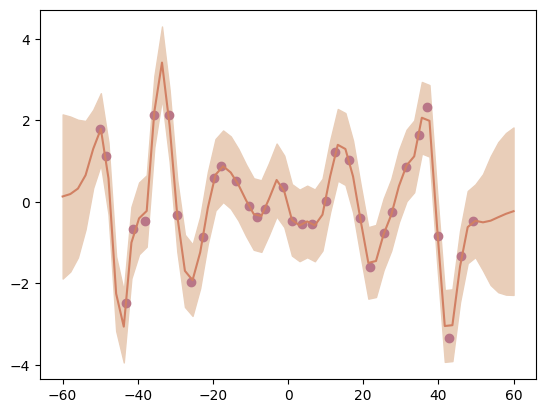

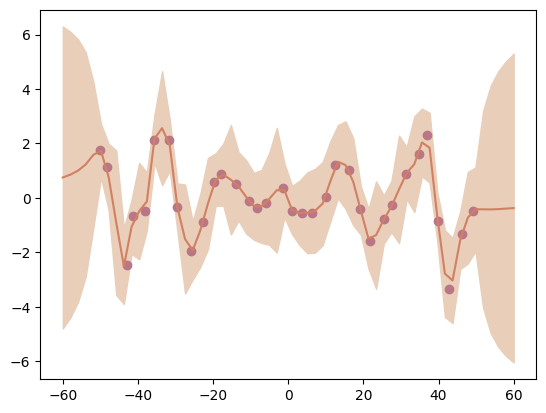

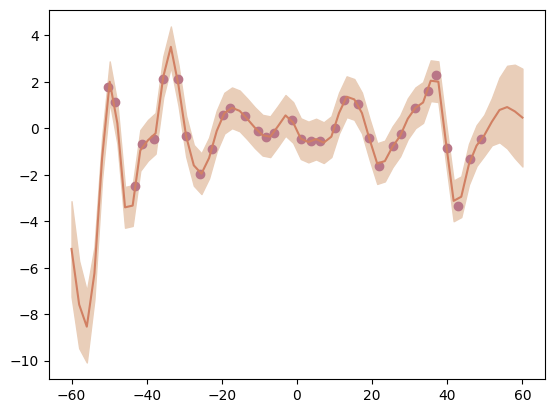

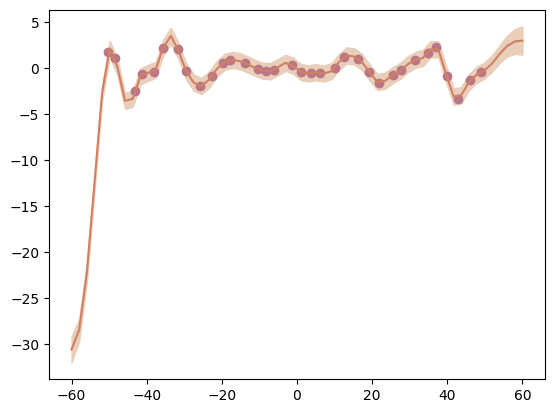

In [26]:
if __name__ == "__main__":
    data = open("/Users/cindychen/Documents/ML_HW05/data/input.data" , mode = "r")
    lines = np.zeros([34,2] , dtype = np.float64)
    for i , line in enumerate(data):
        x, y  = line.split(" ")
        lines[i,0] = x
        lines[i,1] = y

    ## Gaussian process regression
    ## setting sigma = 1, beta = 5, alpha = 1 and length scale = 5
    sigma, beta, alpha, length_scale = 1, 5, 1, 5
    new_point = np.linspace(-60 , 60 , 60)
    model = Gaussian_Process(lines , beta , sigma , alpha , length_scale)
    mu , cov = model.predict(new_point)
    model.show(mu , cov, new_point)

    ## optimize parameter
    res  = model.optimize(sigma ,alpha, length_scale)
    sigma_opt , alpha_opt , length_scale_opt = res.x[0] , res.x[1] , res.x[2]
    model2 = Gaussian_Process(lines , beta , sigma_opt , alpha_opt , length_scale_opt)
    mu , cov = model2.predict(new_point)
    model2.show(mu , cov , new_point)

    ## setting sigma = 1, beta = 5, alpha = 10 and length scale = 5
    sigma, beta, alpha, length_scale = 1, 5, 10, 5
    new_point = np.linspace(-60 , 60 , 60)
    model = Gaussian_Process(lines , beta , sigma , alpha , length_scale)
    mu , cov = model.predict(new_point)
    model.show(mu , cov, new_point)

    ## setting sigma = 1, beta = 5, alpha = 1 and length scale = 1
    sigma, beta, alpha, length_scale = 1, 5, 1, 10
    new_point = np.linspace(-60 , 60 , 60)
    model = Gaussian_Process(lines , beta , sigma , alpha , length_scale)
    mu , cov = model.predict(new_point)
    model.show(mu , cov, new_point)

From different trying of hyperparameter, we can see that if the value of $\alpha$ is higher than the confidence interval is smoother and the line is even more modify. And if the value of length scale is higher the plot has larger range on the boundary. The optimize result is shown on the second plot, we can see that compare with the first plot it doesn't really show a lot of change but the confidence interval on the boundary is larger and the plot after optimization is not so smoothing than the original plot.

## SVM

In [2]:
class SVM:
    def train(self , args , x , y , x_test , y_test):
        if args[0] == 0 or args[0] == 1:
            cmd = '-t {} -c {} -b 1 -q'.format(args[0] , args[1])
            params = svm_parameter(cmd)
            prob = svm_problem(y , x)
            model = svm_train(prob , params)

            p_labs, p_acc, p_vals = svm_predict(y_test, x_test, model ,'-b 1')

        elif args[0] == 2:
            cmd = '-t {} -c {} -g {} -b 1 -q'.format(args[0] , args[1] , args[2])
            params = svm_parameter(cmd)
            prob = svm_problem(y , x)
            model = svm_train(prob , params)

            p_labs, p_acc, p_vals = svm_predict(y_test, x_test, model ,'-b 1')

        else:
            cmd = '-t {} -g {} -b 1 -q'.format(args[0] , args[1])
            params = svm_parameter(cmd)
            prob = svm_problem(y , x)
            model = svm_train(prob , params)

            p_labs, p_acc, p_vals = svm_predict(y_test, x_test, model ,'-b 1')


    def grid(self , args , x_train , y_train):
        ## doing grid search on different combination of (C,gamma)
        if args[0] == 2:
            C = 10**np.linspace(0 , 4 , 5)
            gamma = 10**np.linspace(-4 , 0 , 5)

            best_model = 0
            best_c , best_g = 0 , 0
            cmd_final = ''
            for c in C:
                for g in gamma:
                    cmd = '-t {} -c {} -g {} -b 1 -q -v 3'.format(args[0] , c ,  g)
                    params = svm_parameter(cmd)
                    prob = svm_problem(y_train , x_train)
                    model = svm_train(prob , params)
                    if model > best_model:
                        cmd_final = cmd
                        best_model = model
                        best_c , best_g = c , g
            print("best model: {}% C: {} Gamma: {}".format(best_model , best_c , best_g))
            return cmd_final

        else:
            C = 10**np.linspace(0 , 4 , 5)

            best_model = 0
            best_c = 0
            cmd_final = ""
            for c in C:
                cmd = '-t {} -c {} -b 1 -q -v 5'.format(args[0] , c)
                params = svm_parameter(cmd)
                prob = svm_problem(y_train , x_train)
                model = svm_train(prob , params)
                if model > best_model:
                    cmd_final = cmd
                    best_model = model
                    best_c = c

            print("best model: {}% C: {}".format(best_model , best_c))
            return cmd_final

    def linear_RBF(self , gamma):
        linear = np.asmatrix(self.x_train)@np.asmatrix(self.x_train).T
        dist = np.sum(np.array(self.x_train)**2 , axis = 1).reshape(-1,1)+ np.sum(np.array(self.x_train)**2 , axis = 1).reshape(-1,1) -\
            2*np.asmatrix(self.x_train)@np.asmatrix(self.x_train).T
        rbf = np.exp((-1 * gamma * dist))

        linear_s = np.asmatrix(self.x_train)@np.asmatrix(self.x_test).T
        dist_s = np.sum(np.array(self.x_train)**2 , axis = 1).reshape(-1,1)+ np.sum(np.array(self.x_test)**2 , axis = 1).reshape(-1,1) -\
            2*np.asmatrix(self.x_train)@np.asmatrix(self.x_test).T
        rbf_s = np.exp((-1 * gamma * dist_s))
        return linear+rbf , linear_s+rbf_s

    



In [3]:
def process(dir , dir_label):
    x_train = open(dir , "r")
    lines = []
    for i , line in enumerate(x_train):
        line = line.strip("\n")
        line = [float(x) for x in line.split(',')]
        lines.append(line)
    
    y_train = open(dir_label , "r")
    labels = []
    for l in y_train:
        l = l.strip("\n")
        labels.append(int(l) - 1)
    return lines , labels

### A. Try different kernels function and compare the performance

### a. Linear Kernel 
Use linear kernel first and setting the c to 1. Linear kernel is computed as: $x'y$. The accuracy of the linear kernel is 95.48%.

In [4]:
train_dir = "/Users/cindychen/Documents/ML_HW05/data/X_train.csv"
train_dir_label = "/Users/cindychen/Documents/ML_HW05/data/Y_train.csv"
test_dir = "/Users/cindychen/Documents/ML_HW05/data/X_test.csv"
test_dir_label = "/Users/cindychen/Documents/ML_HW05/data/Y_test.csv"

x_train , y_train = process(train_dir ,train_dir_label)
x_test , y_test = process(test_dir , test_dir_label)

## try different kernel
model = SVM()
kernel = 0 ## linear kernel
c = 1
model.train([kernel , c] , x_train , y_train , x_test , y_test)

Accuracy = 95.48% (2387/2500) (classification)


### b. Polynomial Kernel 
Use polynomial kernel and setting c to 10. Polynomial kernel is computed as: $(\gamma x'y+c_0)^{degree}$. The accuracy of the kernel is 93.72%.

In [5]:
## polynomial kernel
kernel = 1 ### polynomial kernel
c = 10
model.train([kernel , c] , x_train , y_train , x_test , y_test)

Accuracy = 93.72% (2343/2500) (classification)


### c. Radial Basis Function Kernel 
Use Radial Basis Function kernel and setting c to 10 gamma as default value 1/784. Radial Basis Function kernel is computed as: $exp(-\gamma|u-v|^2)$. The accuracy of the kernel is 96.48%.

In [6]:
## RBF kernel
kernel = 2 ### RBF kernel
c = 10
gamma = 1/784 ### the default value of the kernel
model.train([kernel,c,gamma] , x_train , y_train , x_test , y_test)

Accuracy = 96.48% (2412/2500) (classification)


Compare the result of the three kernels, we can find that RBF kernel has the best result.

### B. Use Grid-Search to find the best parameters for the kernel and applying with cross-validation.

### a. Grid Search for Linear Kernel

In [7]:
### try to use grid search to find the best parameter of C in linear kernel
args = [0]
model.grid(args , x_train , y_train)

Cross Validation Accuracy = 96.62%
Cross Validation Accuracy = 96.8%
Cross Validation Accuracy = 96.66%
Cross Validation Accuracy = 96.24%
Cross Validation Accuracy = 96.6%
best model: 96.8% C: 10.0


'-t 0 -c 10.0 -b 1 -q -v 5'

From the result of grid search, we found that when c equals 10 the cross validation has the best result. Apply the parameter we received from grid search and make prediction on the test data, the accuracy of the test data is 95.52%.

In [8]:
## train model with linear kernel given c = 10 
kernel = 0 ### linear kernel
c = 10
model.train([kernel , c ] , x_train , y_train , x_test , y_test)

Accuracy = 95.52% (2388/2500) (classification)


### b. Grid Search for Polynomial Kernel

In [14]:
### try to use grid search to find the best parameter of C in polynomial kernel
args = [1] ### Polynomial kernel
model.grid(args , x_train , y_train)

Cross Validation Accuracy = 64.04%
Cross Validation Accuracy = 94.5%
Cross Validation Accuracy = 96.86%
Cross Validation Accuracy = 97.82%
Cross Validation Accuracy = 98.02%
best model: 98.02% C: 10000.0


'-t 1 -c 10000.0 -b 1 -q -v 5'

From the result of grid search, we found that when c equals 10000 the cross validation has the best result. Apply the parameter we received from grid search and make prediction on the test data, the accuracy of the test data is 97.56%.

In [9]:
## train model with Polynomial kernel given c = 10000 
kernel = 1 ### Polynomial kernel
c = 10000
model.train([kernel , c] , x_train , y_train , x_test , y_test)

Accuracy = 97.56% (2439/2500) (classification)


### c. Grid Search for RBF Kernel

In [9]:
### try to use grid search to find the best parameter of C in polynomial kernel
args = [2] ### RBF kernel
model.grid(args , x_train , y_train)

Cross Validation Accuracy = 93.8%
Cross Validation Accuracy = 96.38%
Cross Validation Accuracy = 97.74%
Cross Validation Accuracy = 97.1%
Cross Validation Accuracy = 30.32%
Cross Validation Accuracy = 96.16%
Cross Validation Accuracy = 97.12%
Cross Validation Accuracy = 97.94%
Cross Validation Accuracy = 97.4%
Cross Validation Accuracy = 30.5%
Cross Validation Accuracy = 97.1%
Cross Validation Accuracy = 97.3%
Cross Validation Accuracy = 98.18%
Cross Validation Accuracy = 97.44%
Cross Validation Accuracy = 30.74%
Cross Validation Accuracy = 96.84%
Cross Validation Accuracy = 97.06%
Cross Validation Accuracy = 98.1%
Cross Validation Accuracy = 97.06%
Cross Validation Accuracy = 30.94%
Cross Validation Accuracy = 96.64%
Cross Validation Accuracy = 97.14%
Cross Validation Accuracy = 98.24%
Cross Validation Accuracy = 97.26%
Cross Validation Accuracy = 30.86%
best model: 98.24000000000001% C: 10000.0 Gamma: 0.01


'-t 2 -c 10000.0 -g 0.01 -b 1 -q -v 3'

From the result of grid search, we found that when c equals 10000 and gamma equals 0.01 the cross validation has the best result. Apply the parameter we received from grid search and make prediction on the test data, the accuracy of the test data is 98.2%.

In [12]:
## train model with RBF kernel given c = 10000 and gamma = 0.01
kernel = 2 ### RBF kernel
c = 10000
gamma = 0.01
model.train([kernel , c , gamma] , x_train , y_train , x_test , y_test)

Accuracy = 98.2% (2455/2500) (classification)


### C. Define a new kernel by ourselves